# Introduction
In the last notebook we saw that MLPs with multiple layers are pretty good at coming up with names. In this notebook we dive deep into the network to understand what is going on and how to do diagnostics.

We will go though the following:

* Initialization of Weights
* Activations
* Gradients
* Pytorchifying the Code

# Libraries

In [1]:
%matplotlib inline
%config IPCompleter.use_jedi=False

In [2]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Data
This step is pretty much equiviant of that in the previous notebook, so we will not go into depth on how the dataset is created.

### Reading the Data

In [3]:
# Reading names into a list
with open('../../data/names.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

### Creating Vocabulary

In [4]:
# Building the vocabulary (character to/from index)
chars = sorted(list(set(''.join(names))))
chr_to_idx = {s:i+1 for i,s in enumerate(chars)}; print(chr_to_idx)
chr_to_idx['.'] = 0
idx_to_chr = {i:s for s,i in chr_to_idx.items()}; print(idx_to_chr)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Preparing Dataset

In [5]:
def build_dataset(words: list, block_size: int = 3, verbose: bool = False) -> tuple:
    """
    Description:
        Take a list of words and creates Xs and Ys give
        a block size. E.g. block_size=3 for emma would 
        result in:
            ... ---> e  
            ..e ---> m  
            .em ---> m  
            emm ---> a  
            mma ---> . 
        Stored in a (n, 3) tensor
    Inputs:
        words: List of words
        block_size: The context window
        verbose: Where to print the outputs
    Ouputs:
        A (n, block_size) tensor with Xs
        A (n) tensor with Ys
    """
    X, Y = [], []
    for word in words:
        if verbose:
            print(word)
        context = [0] * block_size
        for char in word + '.':
            idx = chr_to_idx[char]
            X.append(context)
            Y.append(idx)
            if verbose:
                print(''.join(idx_to_chr[i] for i in context), idx_to_chr[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [6]:
# Putting names in random order
random.shuffle(names)

# Creating split indices
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

In [7]:
# Building training, validation and test sets
Xtr, Ytr = build_dataset(names[:n1]); print(Ytr.size())
Xval, Yval = build_dataset(names[n1:n2]); print(Yval.size())
Xtest, Ytest = build_dataset(names[n2:]); print(Ytest.size())

torch.Size([182691])
torch.Size([22799])
torch.Size([22656])


# Building Network
We build a similar MLP to that in the previous notebook.

In [8]:
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = len(chr_to_idx)

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Weights and biases
W1 = torch.randn([n_embd * block_size, n_hidden])
b1 = torch.randn([n_hidden])
W2 = torch.randn([n_hidden, vocab_size])
b2 = torch.randn([vocab_size])

# Placing parameters in list
parameters = [C, W1, b1, W2, b2]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 11897


# Training
We use the same training loop as in the previous notebook. We have, however, refactored a bit, and defined a method for calculating the loss without messing with the gradients.

In [9]:
@torch.no_grad() # Decorator disables gradient tracking
def split_loss(split: str = 'train', print_loss: bool = False) -> None:
    """
    Description:
        Prints the loss of a chosen split
    Inputs:
        split: train, valid, or test
    """
    x,y = {
        'train': (Xtr, Ytr),
        'valid': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) 
    
    if print_loss:
        print(split, loss.item())
    else :
        return loss.item()

In [10]:
losses = {"Train": [], "Val": []}

In [11]:
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 10000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")

      0/ 100000: 25.5196
  10000/ 100000: 2.1649
  20000/ 100000: 2.6376
  30000/ 100000: 2.2202
  40000/ 100000: 2.1914
  50000/ 100000: 1.9565
  60000/ 100000: 2.1624
  70000/ 100000: 2.2716
  80000/ 100000: 2.2233
  90000/ 100000: 2.2609


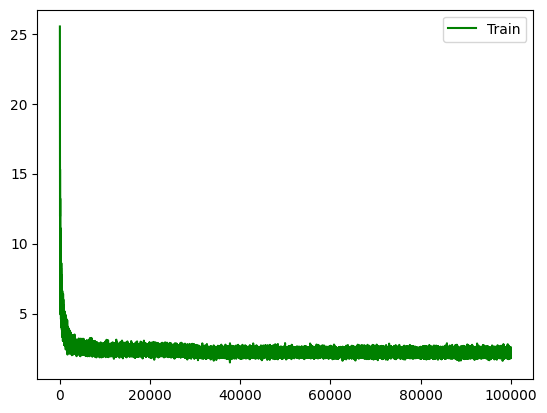

In [12]:
# Plotting training and validation losses
xs = list(range(1, len(losses["Train"])+1))
plt.plot(xs, losses["Train"], label = "Train", color="green")
#plt.plot(xs, losses["Val"], label = "Valid", color="red")
plt.legend()
plt.show()

In [13]:
split_loss("train", print_loss=True)
split_loss("valid", print_loss=True)

train 2.1923835277557373
valid 2.206544876098633


# Generating Names

In [14]:
number_of_names = 20

for _ in range(number_of_names):
    
    char_idx = []
    context = [0] * block_size # Initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # Embeddings for context
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [idx]
        char_idx.append(idx)
        if idx == 0:
            break
    
    print(''.join(idx_to_chr[char_idx] for char_idx in char_idx))

anay.
najalazell.
daye.
kavileanay.
corielao.
meirin.
lavendley.
andel.
hila.
egt.
mavarceara.
meocton.
karissy.
amra.
tamelynn.
vie.
dry.
mon.
mis.
aley.


# Analyses
We will now go through the model above and find out how to make it better.

### Initialization: Part I - Terrible start to training!
If we look at the losses output by the model, we can see that the initial loss is way higher than all the training losses. This is of cause expected, at we initialize the weights using random numbers. But there are things we can do to ensure a better initial loss. E.g. we attempt to make sure that the initial model predicts the 27 output-letters uniformly in stead of randomly. 

We will start out by calculating the expected initial loss if the propabilities of the outputs were uniformly distributed.

In [15]:
# Estimating the loss at uniform distribution
-torch.tensor(1/27).log()

tensor(3.2958)

We can illustrate this example further by comparing the loss for a uniformly distributed tensor vs a randomly initialized tensor.

In [16]:
# Uniform
logits = torch.tensor([0.15,0.15,0.15,0.15])
probs = torch.softmax(logits, dim=0)
losses = -probs.log()
logits, probs, losses

(tensor([0.1500, 0.1500, 0.1500, 0.1500]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor([1.3863, 1.3863, 1.3863, 1.3863]))

In [17]:
# Random
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
losses = -probs.log()
logits, probs, losses

(tensor([ 0.9582,  0.0691,  0.3678, -1.0945]),
 tensor([0.4777, 0.1963, 0.2647, 0.0613]),
 tensor([0.7389, 1.6280, 1.3292, 2.7916]))

We can see that the logits of the randomly initialized tensor have more "extreme" values than those from the uniform distribution. If we break the training loop for our model (above) after one epoch, we can also inspect the logits there, and conclude that the logits contain "extreme" values.

We will now attempt to find a way to make the initial loss lower by initializing the weights, such that the logits will be uniformly distributed (it is the most easy just to get them to all very close to zero).

We make the logits closer to zero in the following part of the network:

* logits = h @ W2 + b2
  * We can see that the biases **b2** adds directly to the logits. By initializing **b2** as zero, we can move the logits closer to zero.
  * We can also scale down **W2** to get the logits closer to zero.

In [18]:
# Attempt 1: Logits towards zero
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = len(chr_to_idx)

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Weights and biases
W1 = torch.randn([n_embd * block_size, n_hidden])
b1 = torch.randn([n_hidden])
W2 = torch.randn([n_hidden, vocab_size]) * 0.01
b2 = torch.randn([vocab_size]) * 0

# Placing parameters in list
parameters = [C, W1, b1, W2, b2]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 11897


In [19]:
# Attempt 1: Training
losses = {"Train": [], "Val": []}
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 10000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")

split_loss('train', print_loss=True)
split_loss('valid', print_loss=True)

      0/ 100000: 3.3160
  10000/ 100000: 2.3132
  20000/ 100000: 2.0411
  30000/ 100000: 2.0656
  40000/ 100000: 1.9051
  50000/ 100000: 2.3013
  60000/ 100000: 2.1284
  70000/ 100000: 2.1933
  80000/ 100000: 2.1109
  90000/ 100000: 2.0664
train 2.1064627170562744
valid 2.150545120239258


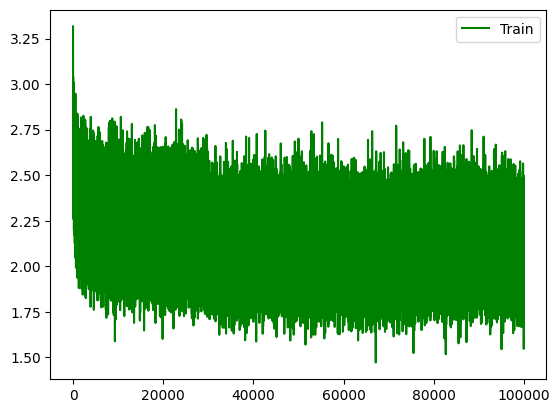

In [20]:
# Attempt 1: Plotting training and validation losses
xs = list(range(1, len(losses["Train"])+1))
plt.plot(xs, losses["Train"], label = "Train", color="green")
#plt.plot(xs, losses["Val"], label = "Valid", color="red")
plt.legend()
plt.show()

### Initialization: Part II - Limiting dead neurons
This time we will be taking a look at the activations. That is, we will be looking at this part of the forward pass:

* h = torch.tanh(h_preactiv)

What **tanh** does is to squeeze the pre-activation-values to numbers between -1 and 1. Now we will inspect **h** after one epoch (do this manually with break).

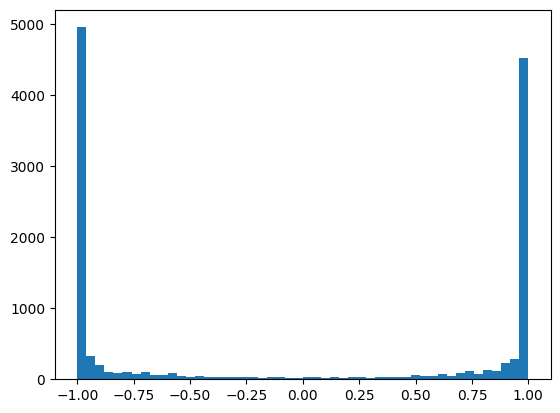

In [21]:
# Plotting distribution of h values
plt.hist(h.view(-1).tolist(), 50);

We can see that **tanh** is very active. The reason for this can be found by taking a few steps back.

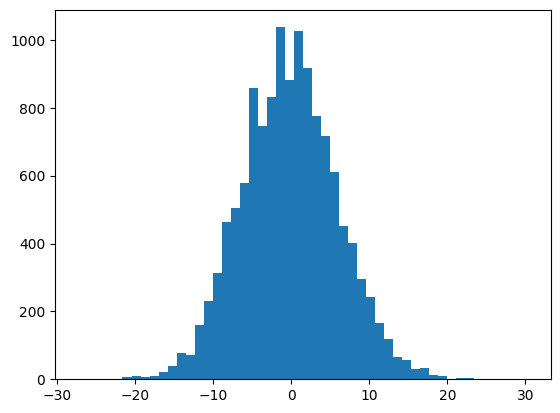

In [22]:
# Distribution of pre-activations
plt.hist(h_preactiv.view(-1).tolist(), 50);

We can see that the **pre-activations** are distributed between roughly -20 and 20. In the next plot we have plottet values between -20 and 20 versus tanh of the values.

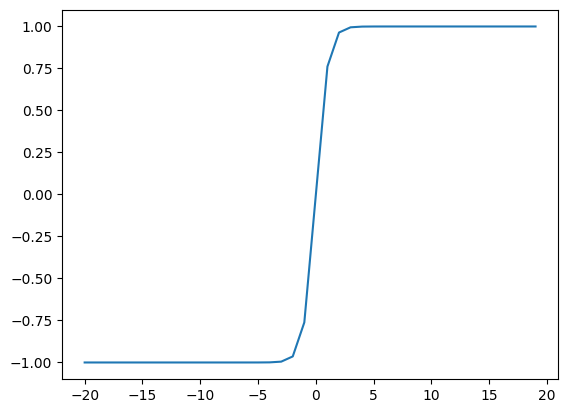

In [23]:
# Values vs tanh(values)
x1 = torch.tensor(range(-20,20,1))
y1 = torch.tanh(x1)
plt.plot(x1,y1)

It is now clear why most of the values get bumped to -1 and 1, as values above 6 and below -6 will be bumped to 1 and -1 respectively. When calculating the gradient during the backward pass, the gradient of the activations is being killed because:

self.grad += (1 - t\*\*2) * out.grad 

As we can see:

self.grad += 0 * out.grad

If the the activation instead had been close to zero, the out.grad would just be passed along. Let's examine how bad it looks for our neurons.

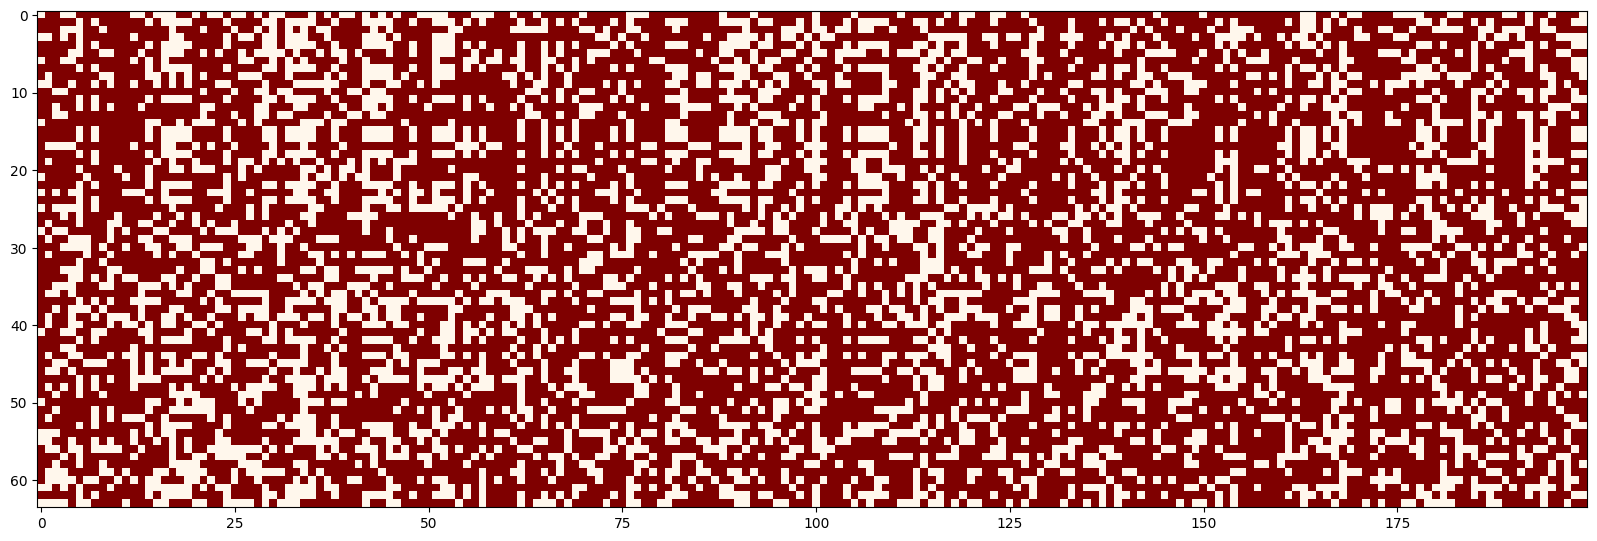

In [24]:
plt.figure(figsize=(20,10))
cmap = plt.cm.OrRd
cmap.set_bad(color='black')
plt.imshow(h.abs() > 0.99, cmap=cmap, interpolation='nearest')

Each column is a neuron, and it column is fully black it means that the neuron is dead, and information can no longer flow through it. That is, no matter what data you feed the neuron it can only fire as 1 or -1.

This problem is not unique to tahn as an activation function:

* Sigmoid: Values under/over -10/10 get squashed to -1/1
* ReLU: Values under zero get squashed to 0
* leaky-ReLU: Doesn't really suffer from this problem
* ELU: Has the same problem for negative values

The problem can be created at initialization but also during training. So the way we solve the problem is by looking at the following equation:

* h_preactiv = emb_cat @ W1 + b1

We want h_preactiv to be closer to zero, and this can be done by setting the b1 to zero and multiplying the W1 by a low number.

In [25]:
# Attempt 2: Pre-activations towards zero
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = len(chr_to_idx)

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Weights and biases
W1 = torch.randn([n_embd * block_size, n_hidden]) * 0.15
b1 = torch.randn([n_hidden]) * 0
W2 = torch.randn([n_hidden, vocab_size]) * 0.01
b2 = torch.randn([vocab_size]) * 0

# Placing parameters in list
parameters = [C, W1, b1, W2, b2]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 11897


In [26]:
# Attempt 2: Training
losses = {"Train": [], "Val": []}
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 10000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")
    break

split_loss('train', print_loss=True)
split_loss('valid', print_loss=True)

      0/ 100000: 3.3197
train 3.2641003131866455
valid 3.264885425567627


We are doing the same diagnosis again.

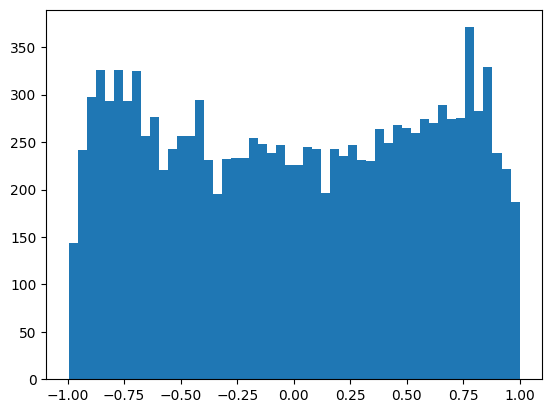

In [27]:
# Plotting distribution of h values
plt.hist(h.view(-1).tolist(), 50);

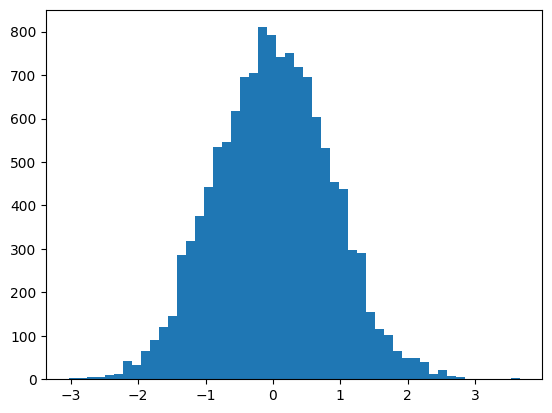

In [28]:
# Distribution of pre-activations
plt.hist(h_preactiv.view(-1).tolist(), 50);

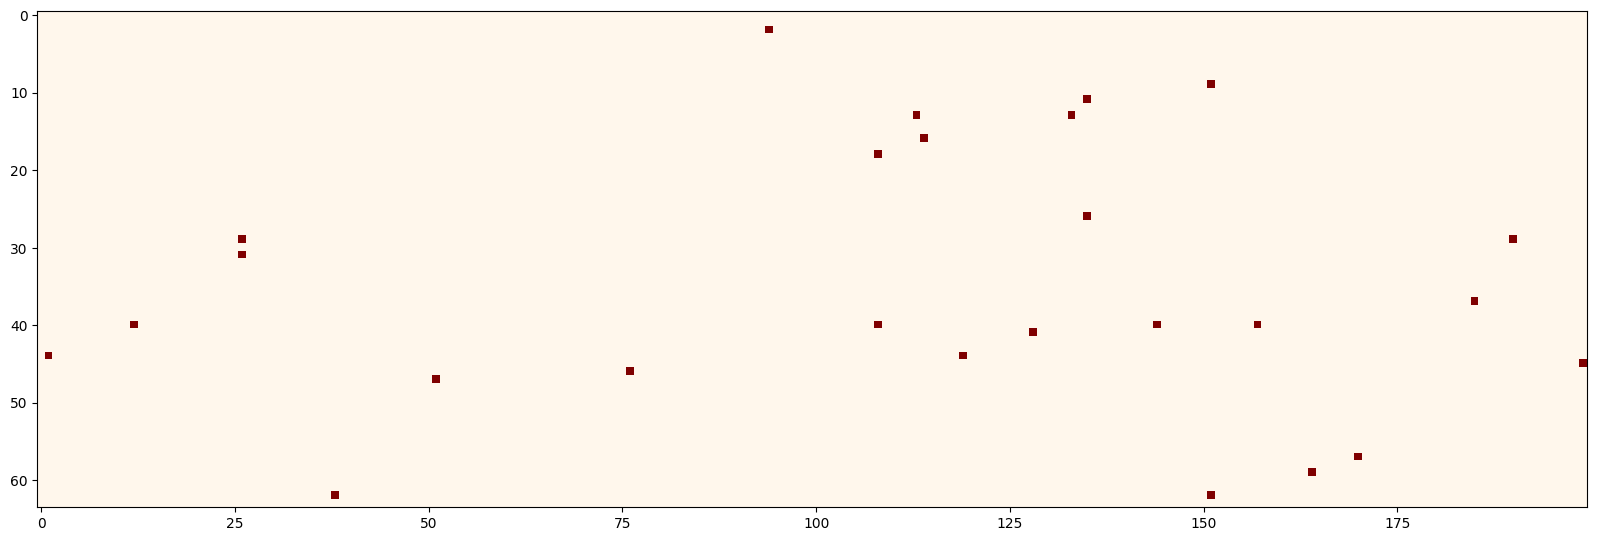

In [29]:
# If all black because no neurons are larger than 0.99
plt.figure(figsize=(20,10))
cmap = plt.cm.OrRd
cmap.set_bad(color='black')
plt.imshow(h.abs() > 0.99, cmap=cmap, interpolation='nearest')

Now that it looks much better, we can train the network again.

In [30]:
# Attempt 2: Training
losses = {"Train": [], "Val": []}
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 10000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")

split_loss('train', print_loss=True)
split_loss('valid', print_loss=True)

      0/ 100000: 3.2726
  10000/ 100000: 2.1042
  20000/ 100000: 2.0006
  30000/ 100000: 2.1785
  40000/ 100000: 2.1303
  50000/ 100000: 2.1386
  60000/ 100000: 2.2783
  70000/ 100000: 1.8722
  80000/ 100000: 2.2136
  90000/ 100000: 1.9725
train 2.0639610290527344
valid 2.114436626434326


The model is now performing quite a bit better!

### Initialization: Part 3 - Getting rid of magic numbers
To get better starting weights and to limit the number of dead neurons we initially multiplied the weights with some small numbers, but how do we determine which numbers to multiply with? In this section we will find out how to do this in an automated way through some examples.

tensor(-0.0061) tensor(0.9921)
tensor(-0.0039) tensor(3.1930)


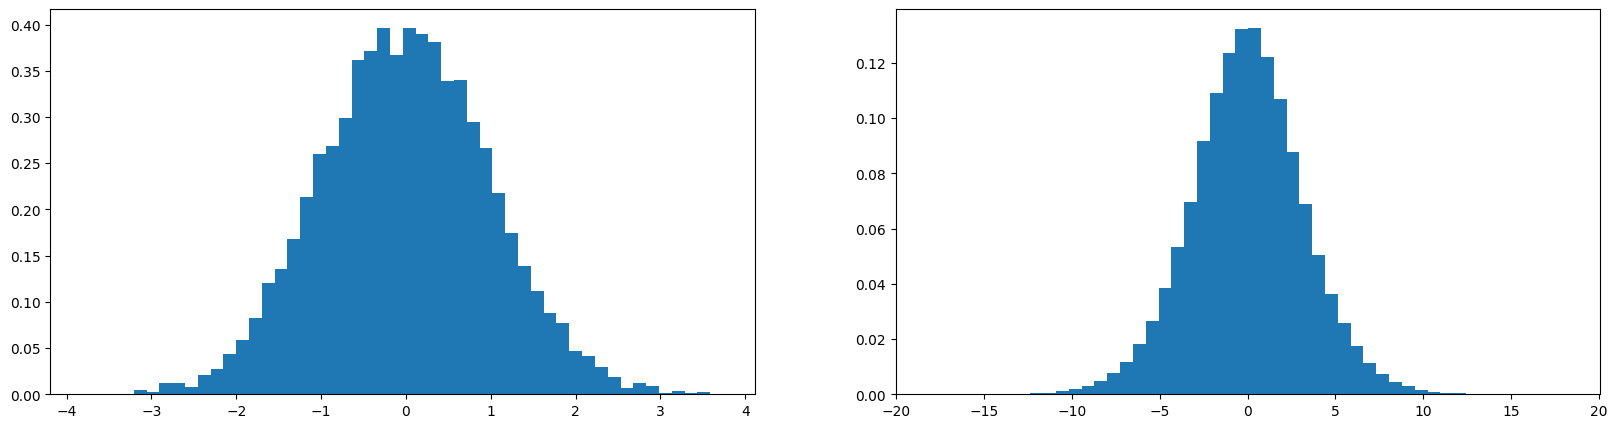

In [31]:
# Example 
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

We can see that though the standard diviation of the input is 1, then after the dot product (pre-activation) the standard diviation is more than 3! We could imagine that as we go though more layers we get more extreme values. We would like to keep it around 1 through out the network. We can get the initial values to be well behaved by using the [Kaiming Initialization](https://arxiv.org/abs/1502.01852), which multiplies the initialized weights with $\frac{gain} {\sqrt[]2}$, where gain depends on the [activation function](https://pytorch.org/docs/stable/nn.init.html). 

Here we normalize the weights to standard diviation 1, but if we wanted to do it for e.g. **tanh** activation, we would have to multiply by $\frac{5/3} {\sqrt[]2}$

tensor(-0.0033) tensor(0.9851)
tensor(0.0009) tensor(0.9919)


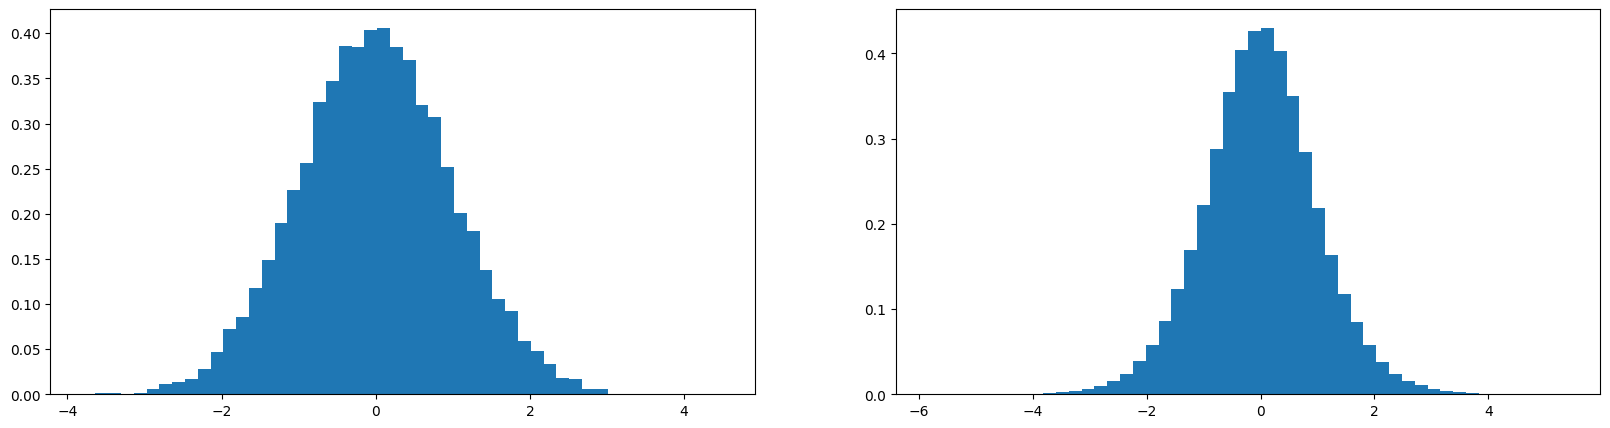

In [32]:
# Example with Kaiming Initialization and Tanh
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * (1/(10 ** 0.5))
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

The initialization used to be very important, but with the invention of newer training techniques such as better optimizers (adam) and batch normalization, it has become less important as we will see in the following sections. But first let train the network again with this new initialization.

In [33]:
# Attempt 3: Kaiming initialization
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = len(chr_to_idx)

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Weights and biases
W1 = torch.randn([n_embd * block_size, n_hidden]) * ((5/3)/((n_embd * block_size) ** 0.5))
b1 = torch.randn([n_hidden]) * 0.01
W2 = torch.randn([n_hidden, vocab_size]) * 0.01
b2 = torch.randn([vocab_size]) * 0

# Placing parameters in list
parameters = [C, W1, b1, W2, b2]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 11897


In [34]:
# Attempt 3: Training
losses = {"Train": [], "Val": []}
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 10000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")
split_loss('train', print_loss=True)
split_loss('valid', print_loss=True)

      0/ 100000: 3.3279
  10000/ 100000: 2.2333
  20000/ 100000: 2.2290
  30000/ 100000: 2.0447
  40000/ 100000: 1.8404
  50000/ 100000: 2.0867
  60000/ 100000: 2.0942
  70000/ 100000: 2.0380
  80000/ 100000: 2.1844
  90000/ 100000: 2.1910
train 2.0671966075897217
valid 2.1214888095855713


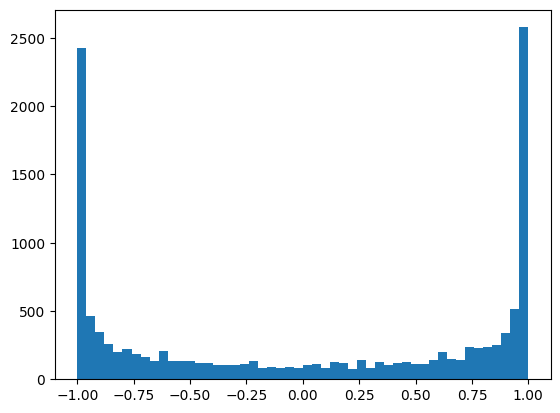

In [35]:
# Plotting distribution of h values after training
plt.hist(h.view(-1).tolist(), 50);

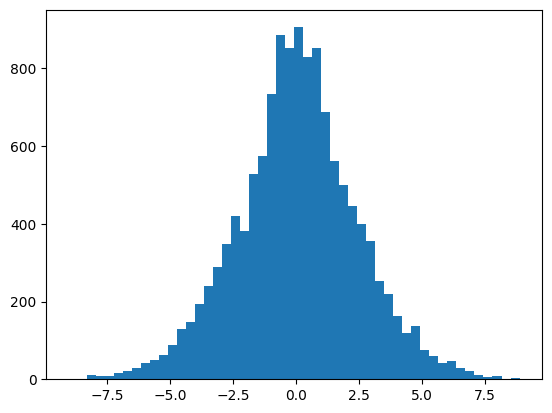

In [36]:
# Distribution of pre-activations after training
plt.hist(h_preactiv.view(-1).tolist(), 50);

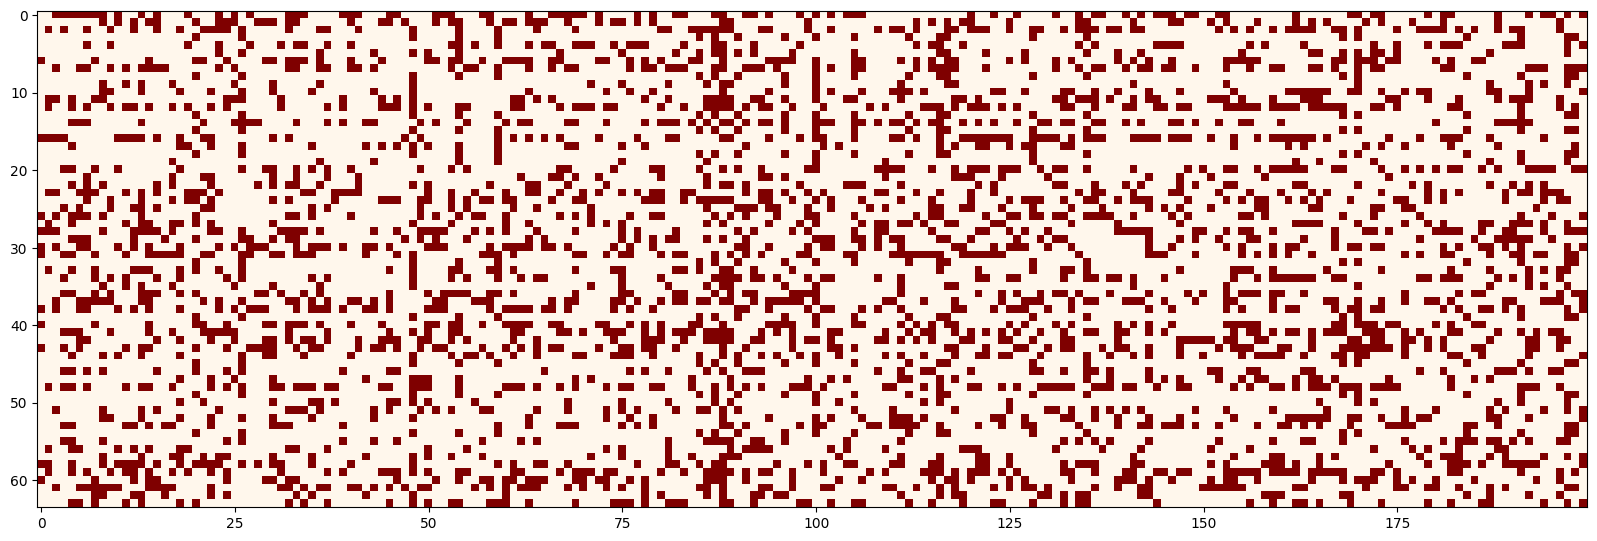

In [37]:
# We can see that many neuron values are larger than 0.99 after training
plt.figure(figsize=(20,10))
cmap = plt.cm.OrRd
cmap.set_bad(color='black')
plt.imshow(h.abs() > 0.99, cmap=cmap, interpolation='nearest')

We get a roughly the same result, just without using magic numbers to initialize our network. Also, we can see that after training some rounds we run into the same problems again of dead neurons. Let's jump to batch normalization to see if it can fix some of these problems.

### Batch Normalization
Here we will implement [bach normalization](https://arxiv.org/abs/1502.03167), which will allow us to train really deep networks. We basically just normalize the hidden state such that is has mean 0 and strandard diviation 1, and we can do that because this operation is differentiable.

If we do this alone, we will inhibit the networks ability to train, as we force the values into a small space. We also want the network to be able to **shift** the distribution, which is why we add a shifting ability (bngain and bnbias). Due to the normalization we also have to remove the normal bias, **b1**, as it in practice gets replaces with the **bnbias**.

In [38]:
# Attempt 4: Bachnorm initialization
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = len(chr_to_idx)

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Weights and biases
W1 = torch.randn([n_embd * block_size, n_hidden]) * (5/3)/((n_embd * block_size) ** 0.5)
#b1 = torch.randn([n_hidden]) * 0.01
W2 = torch.randn([n_hidden, vocab_size]) * 0.01
b2 = torch.randn([vocab_size]) * 0

# Batch Norm Shifting weights
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# Placing parameters in list
parameters = [C, W1, W2, b2, bngain, bnbias]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 12097


In [39]:
# Attempt 4: Updating split loss to include bngain and bnbias
@torch.no_grad()
def split_loss(split: str = 'train', print_loss: bool = False) -> None:
    """
    Description:
        Prints the loss of a chosen split
    Inputs:
        split: train, valid, or test
    """
    x,y = {
        'train': (Xtr, Ytr),
        'valid': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h_preactiv = bngain * (h_preactiv - h_preactiv.mean(0, keepdim=True)) / h_preactiv.std(0, keepdim=True) * bnbias
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) 
    
    if print_loss:
        print(split, loss.item())
    else :
        return loss.item()

In [40]:
# Attempt 4: Training with batch normalization
losses = {"Train": [], "Val": []}
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 #+ b1
    h_preactiv = bngain * (h_preactiv - h_preactiv.mean(0, keepdim=True)) / h_preactiv.std(0, keepdim=True) * bnbias
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 10000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")
split_loss('train', print_loss=True)
split_loss('valid', print_loss=True)

      0/ 100000: 3.2958
  10000/ 100000: 2.2912
  20000/ 100000: 2.3275
  30000/ 100000: 2.0417
  40000/ 100000: 2.3709
  50000/ 100000: 2.0764
  60000/ 100000: 2.1133
  70000/ 100000: 2.2118
  80000/ 100000: 2.0838
  90000/ 100000: 2.0886
train 2.176746129989624
valid 2.191257953643799


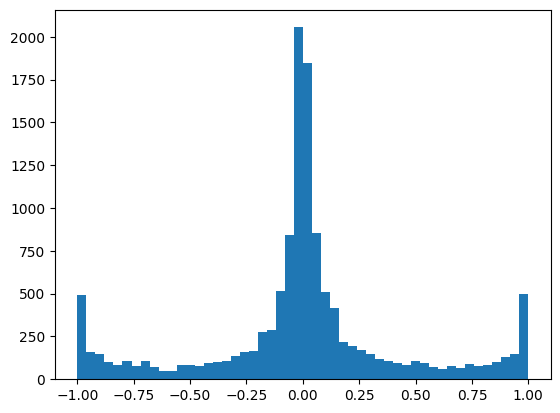

In [41]:
# Plotting distribution of h values
plt.hist(h.view(-1).tolist(), 50);

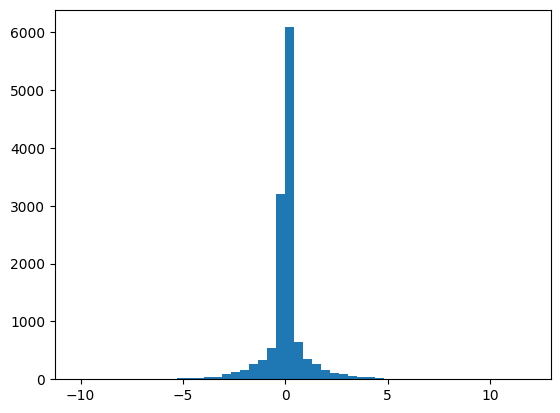

In [42]:
# Distribution of pre-activations
plt.hist(h_preactiv.view(-1).tolist(), 50);

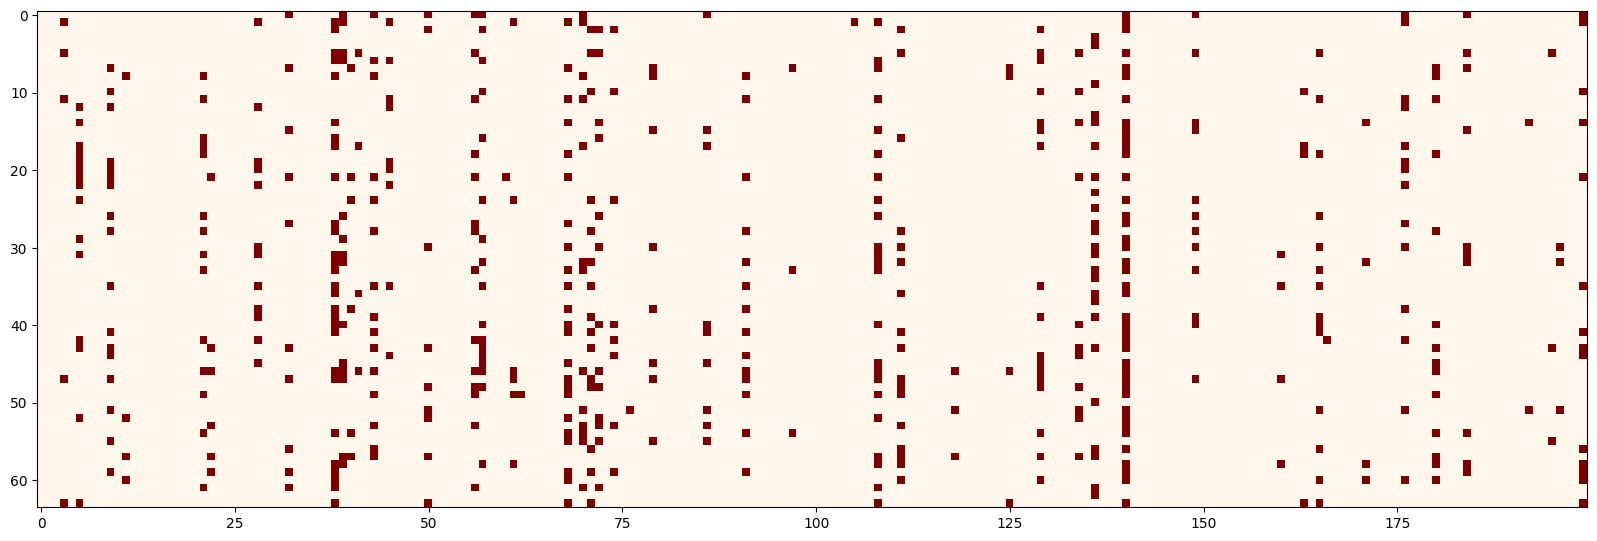

In [43]:
# Imshow 
plt.figure(figsize=(20,10))
cmap = plt.cm.OrRd
cmap.set_bad(color='black')
plt.imshow(h.abs() > 0.99, cmap=cmap, interpolation='nearest')

We did not get any gain in performance, but the bach normalization will help us train much deeper networks, as the activations that go into the following layers will have a standard diviation of 1 and mean 0.

One property of batch normalization that is not so good is that the mean and standard diviation are dependent on all the samples in a batch, thus it is variable and can be messing things up at inference time, where the input is usually just a simple sample. People have be trying to replace the batch normalization and use other types of normalization, and we will get to that further later.

What is usually done to make the inference sensible after using batch norm is to calculate the mean and std for the final batch, and then use those values at inference time.

In [44]:
# Calibrating the batch norm at the end of training
with torch.no_grad():
    # Pass the training set through
    emb = C[Xtr]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    bnmean = h_preactiv.mean(0, keepdim=True)
    bnstd = h_preactiv.std(0, keepdim=True)

In [45]:
# Attempt 5: Split loss for batchnorm
@torch.no_grad()
def split_loss(split: str = 'train', print_loss: bool = False) -> None:
    """
    Description:
        Prints the loss of a chosen split
    Inputs:
        split: train, valid, or test
    """
    x,y = {
        'train': (Xtr, Ytr),
        'valid': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h_preactiv = bngain * (h_preactiv - bnmean) / bnstd * bnbias
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) 
    
    if print_loss:
        print(split, loss.item())
    else :
        return loss.item()

In [46]:
split_loss('train', print_loss=True)
split_loss('valid', print_loss=True)

train 2.176746129989624
valid 2.1912872791290283


The performance took a small hit, but when training deep networks this comprimise is made up for. Alternatives to batch normalization that have become popular are group-normalization and layer-normalization.

# Pytorchfying the Code
Now that we understand the concepts of kaiming initialization and batchnormalization it is time to recreate Pytorch's built-in functions and classes instead.

In [47]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        """ Initializes Weights """
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        """ Forward Pass """
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        """ Returning  All Parameters """
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [64]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        """ Initializing Batchnorm Weights """
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Batchnorm Shift Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # Running batchnorm Mean and Variance
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        """ Forward Pass and Buffers """
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [49]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

Now we can do all the same initializations as we did with the previous weights. Here we just add a few more hidden layers.

In [50]:
# Initializing Weights
n_embd = 10
n_hidden = 100

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Layers
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

# Adjusing initialization of layers
with torch.no_grad():
    # Making last layer less confident
    layers[-1].weight *= 0.1
    
    # Applying Kaiming initialization for tanh to all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

# All parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


Now we can train the model!

In [51]:
max_steps = 200000
batch_size = 32
lr = 0.1
lossi = []
ud = []

for step in range(max_steps):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)    
    
    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if step < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif step < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    if not step % 10000:
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log().item() for p in parameters])
    
    # break # Outcomment for full training

      0/ 200000: 3.3171
  10000/ 200000: 1.7045
  20000/ 200000: 2.1691
  30000/ 200000: 2.4346
  40000/ 200000: 2.0519
  50000/ 200000: 1.9051
  60000/ 200000: 1.9005
  70000/ 200000: 1.8734
  80000/ 200000: 2.0241
  90000/ 200000: 2.0339
 100000/ 200000: 1.9478
 110000/ 200000: 2.1779
 120000/ 200000: 1.7563
 130000/ 200000: 2.0381
 140000/ 200000: 2.0341
 150000/ 200000: 1.8633
 160000/ 200000: 1.9818
 170000/ 200000: 2.0855
 180000/ 200000: 1.8265
 190000/ 200000: 2.2857


Finally we write some code for visualizing the statistics both for the training but also for some of the layers.

layer 1 (      Tanh): mean -0.06, std 0.83, saturated: 35.78
layer 3 (      Tanh): mean -0.01, std 0.84, saturated: 39.62
layer 5 (      Tanh): mean -0.01, std 0.85, saturated: 37.78
layer 7 (      Tanh): mean -0.02, std 0.87, saturated: 42.41
layer 9 (      Tanh): mean -0.02, std 0.78, saturated: 22.72


Text(0.5, 1.0, 'activation distribution')

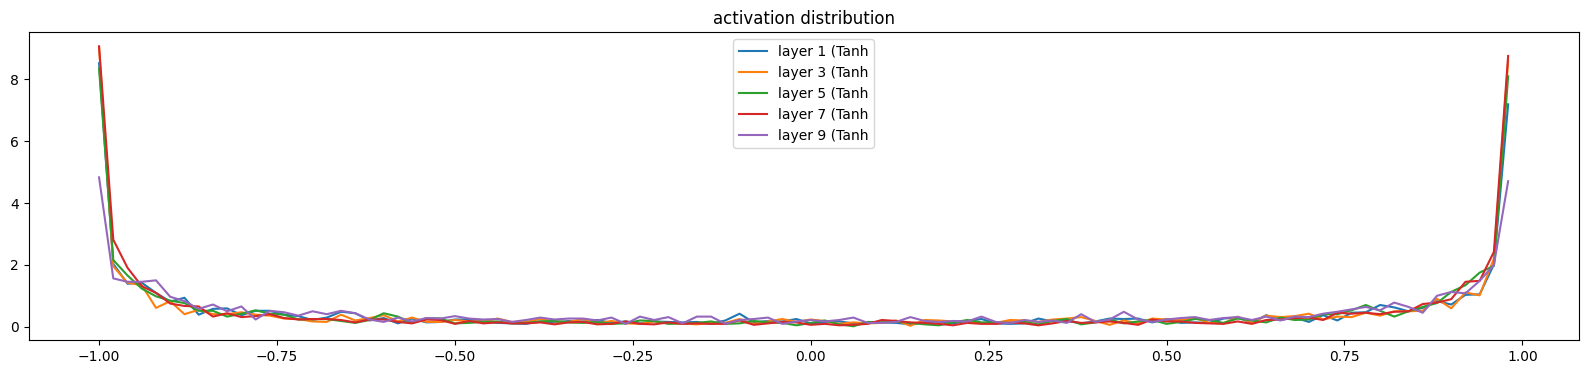

In [52]:
# Visualizing histograms for activations (after one step)
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__:>10}): mean {t.mean():.2f}, std {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Here we have set the gain to 5/3, and we can see that the standard diviation stabilizes to around 0.65 through the layers, while around 5 % of the activations are above 0.97. If we try to set a different gain, e.g. 1, our standard diviation would shrink throughout the layers. Try it! This is why we should use the kaiming initializations.

layer 1 (      Tanh): mean -0.00, std 0.004396, saturated: 0.00
layer 3 (      Tanh): mean 0.00, std 0.003901, saturated: 0.00
layer 5 (      Tanh): mean 0.00, std 0.003746, saturated: 0.00
layer 7 (      Tanh): mean -0.00, std 0.004331, saturated: 0.00
layer 9 (      Tanh): mean -0.00, std 0.004630, saturated: 0.00


Text(0.5, 1.0, 'gradient distribution')

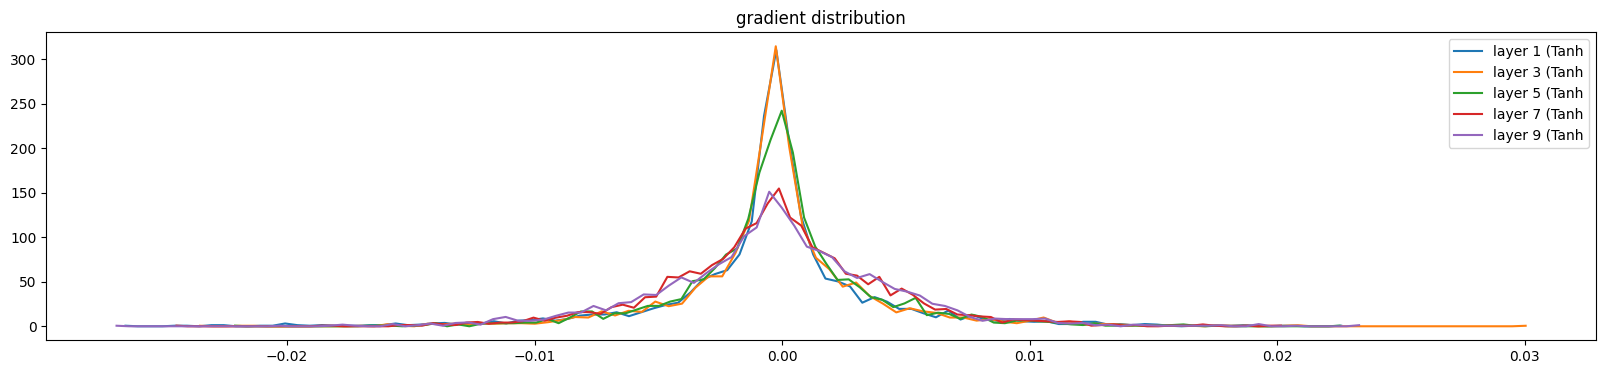

In [53]:
# Visualizing histograms for gradients (after one step)
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:>10}): mean {t.mean():.2f}, std {t.std():.6f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

We can see that the gradient distribution across the layers are similar, and they don't shrink or explode, which is a good thing. Try experimenting with the gain to see what happens.

A few findings:

* If the gain is too high/low
  * The activation distributions differ between layers
  * The gradient distributions differ between layers
* Without tanh
  * The gradients shrink through the layers, making it hard for deep networks to learn
  
Next we will investigate the relationship between weights and update sizes in different ways.

weight   (27, 10): mean +0.0007, std 1.7548e-02, grad:data ratio 1.6920e-02
weight  (30, 100): mean -0.0000, std 1.2160e-02, grad:data ratio 3.2443e-02
weight (100, 100): mean -0.0001, std 8.2404e-03, grad:data ratio 3.7760e-02
weight (100, 100): mean -0.0000, std 8.1081e-03, grad:data ratio 3.7844e-02
weight (100, 100): mean +0.0001, std 7.8825e-03, grad:data ratio 3.7598e-02
weight (100, 100): mean +0.0001, std 9.6288e-03, grad:data ratio 4.9522e-02
weight  (100, 27): mean +0.0000, std 2.4039e-02, grad:data ratio 1.4739e-01


Text(0.5, 1.0, 'gradient distribution')

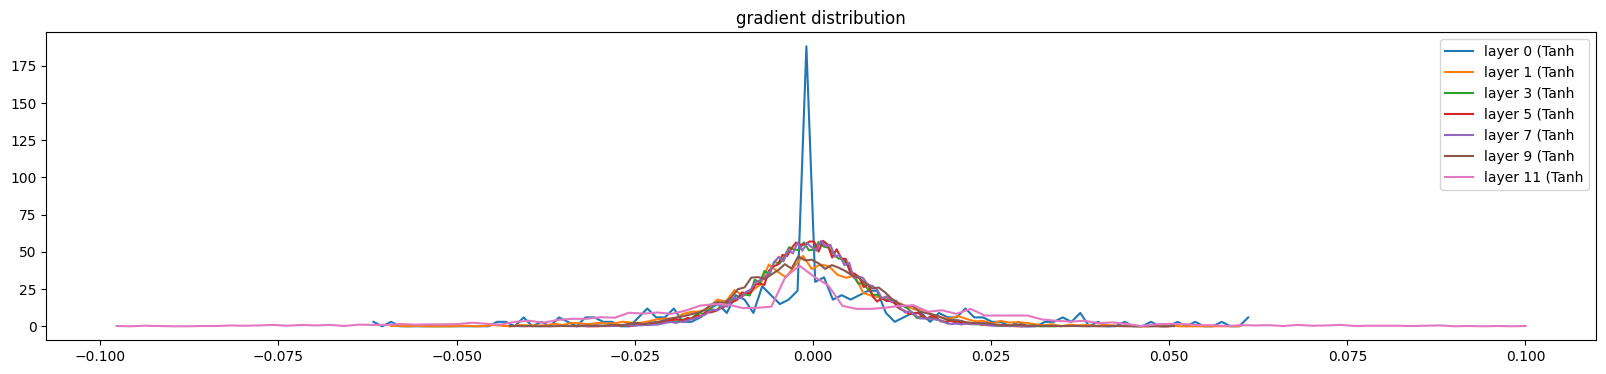

In [54]:
# Visualizing histograms for weights (after one step)
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'weight {str(tuple(p.shape)) : >10}: mean {t.mean():+.4f}, std {t.std():.4e}, grad:data ratio {t.std() / p.std():.4e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

When going though the parameters and evaluating the ratio between the gradients and the values. We don't want the gradients to be bigger than the values they are changing, that is be >1. If we look at the last layer, we can see that the ratio is larger than 1, and that the std is much larger than for the other layers. This means that the last layer trains much faster than the other layers.

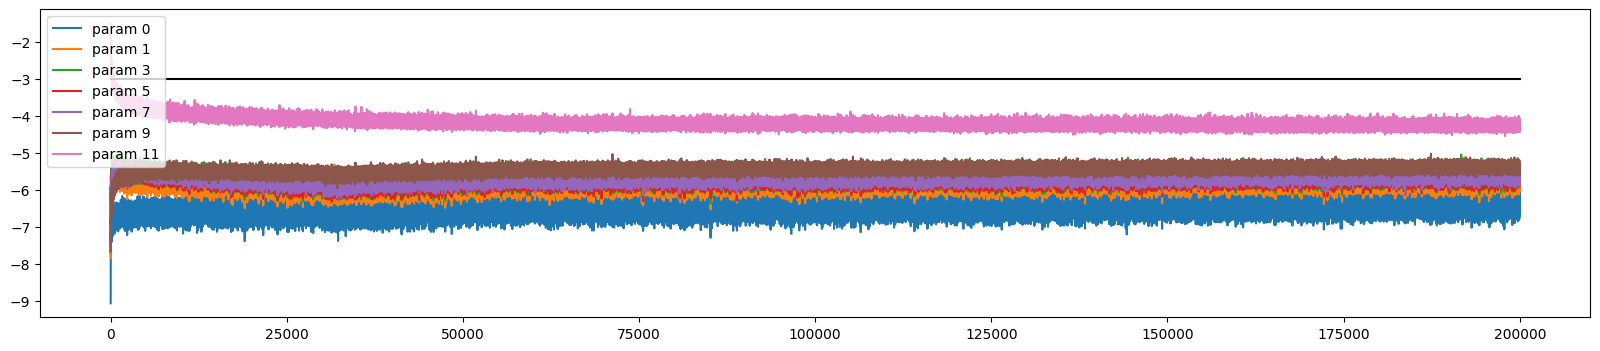

In [55]:
# Visualizing histograms for updates (after multiple steps)
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2: # Only weights, not biases
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

Here we looked at the ratio between updates and the weight in the different layers. If the ratio is much lower than -3, then the learning rate is probably too low.

### Adding BatchNorm
We will now add the batch normalization to avoid the network being so sensitive to setting the correct gain.

In [76]:
# Initializing Weights
n_embd = 10
n_hidden = 100

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Layers
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

# Adjusing initialization of layers
with torch.no_grad():
    # Making last layer less confident
    layers[-1].gamma *= 0.1
    
    # Applying Kaiming initialization for tanh to all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

# All parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [77]:
max_steps = 200000
batch_size = 32
lr = 1
lossi = []
ud = []

for step in range(max_steps):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)    
    
    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if step < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif step < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    if not step % 10000:
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log().item() for p in parameters])
    
    # break # Outcomment for full training

      0/ 200000: 3.3317
  10000/ 200000: 2.0981
  20000/ 200000: 2.2491
  30000/ 200000: 2.1056
  40000/ 200000: 2.6323
  50000/ 200000: 2.4334
  60000/ 200000: 2.0408
  70000/ 200000: 1.6443
  80000/ 200000: 2.2022
  90000/ 200000: 2.1244
 100000/ 200000: 1.9352
 110000/ 200000: 1.9269
 120000/ 200000: 2.5522
 130000/ 200000: 2.1680
 140000/ 200000: 2.3061
 150000/ 200000: 2.1360
 160000/ 200000: 1.8410
 170000/ 200000: 1.7622
 180000/ 200000: 2.1419
 190000/ 200000: 1.9353


We will be running over the same analysis again, but see that this time everything looks wonderful :)

layer 2 (      Tanh): mean -0.00, std 0.78, saturated: 30.16
layer 5 (      Tanh): mean 0.03, std 0.80, saturated: 32.09
layer 8 (      Tanh): mean 0.03, std 0.81, saturated: 29.69
layer 11 (      Tanh): mean -0.02, std 0.81, saturated: 28.78
layer 14 (      Tanh): mean 0.04, std 0.82, saturated: 32.47


Text(0.5, 1.0, 'activation distribution')

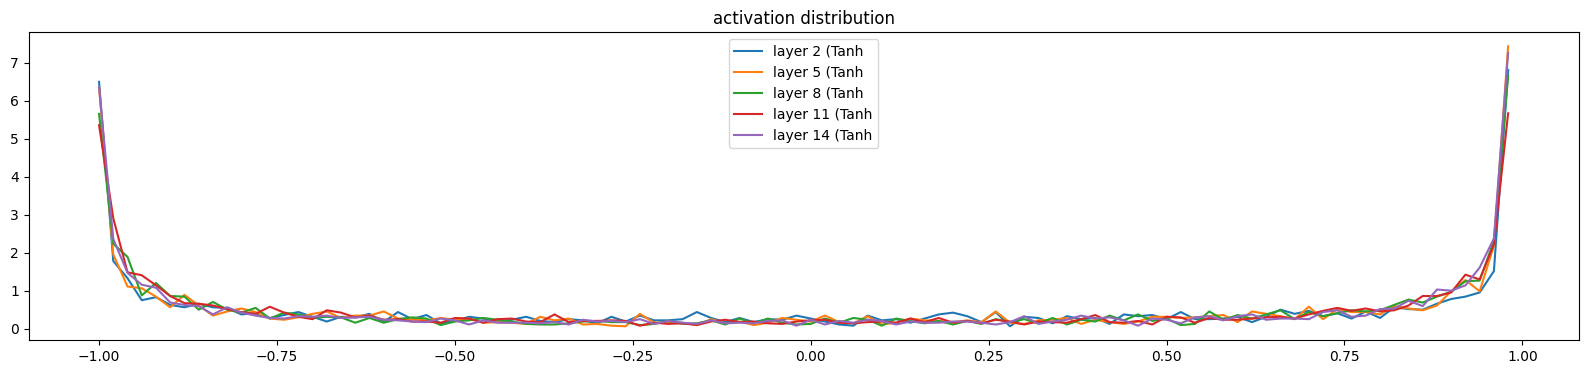

In [78]:
# Visualizing histograms for activations (after one step)
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__:>10}): mean {t.mean():.2f}, std {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.003009, saturated: 0.00
layer 5 (      Tanh): mean 0.00, std 0.002742, saturated: 0.00
layer 8 (      Tanh): mean 0.00, std 0.002385, saturated: 0.00
layer 11 (      Tanh): mean -0.00, std 0.002392, saturated: 0.00
layer 14 (      Tanh): mean -0.00, std 0.003168, saturated: 0.00


Text(0.5, 1.0, 'gradient distribution')

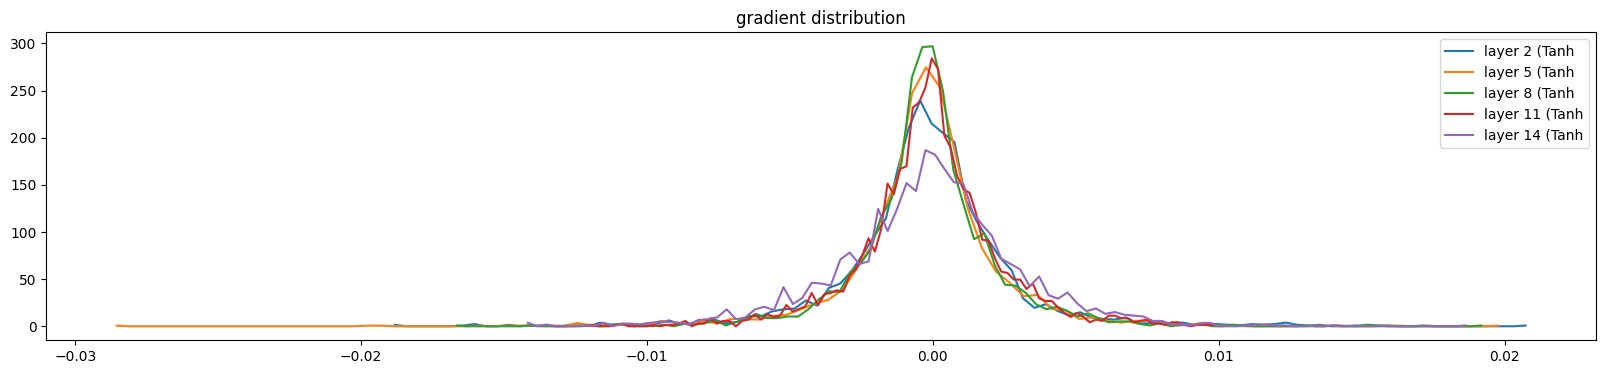

In [79]:
# Visualizing histograms for gradients (after one step)
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:>10}): mean {t.mean():.2f}, std {t.std():.6f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10): mean +0.0000, std 1.0260e-02, grad:data ratio 6.2437e-03
weight  (30, 100): mean -0.0000, std 5.1663e-03, grad:data ratio 7.5580e-03
weight (100, 100): mean -0.0000, std 3.0689e-03, grad:data ratio 8.5164e-03
weight (100, 100): mean -0.0000, std 2.5709e-03, grad:data ratio 8.0326e-03
weight (100, 100): mean -0.0000, std 2.3885e-03, grad:data ratio 8.1647e-03
weight (100, 100): mean +0.0000, std 2.2552e-03, grad:data ratio 7.7252e-03
weight  (100, 27): mean +0.0000, std 4.7565e-03, grad:data ratio 8.2383e-03


Text(0.5, 1.0, 'gradient distribution')

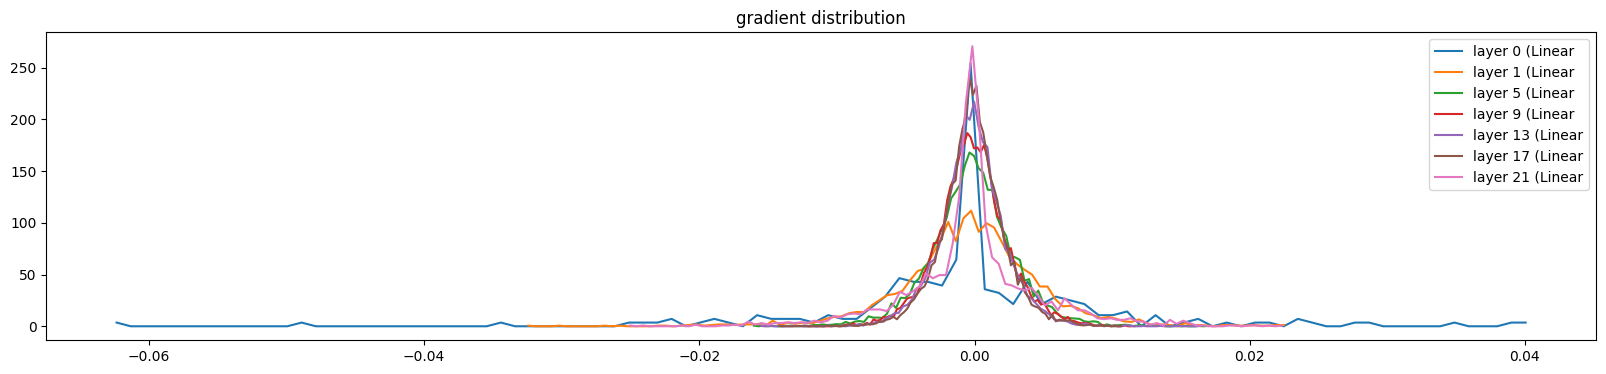

In [80]:
# Visualizing histograms for weights (after one step)
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'weight {str(tuple(p.shape)) : >10}: mean {t.mean():+.4f}, std {t.std():.4e}, grad:data ratio {t.std() / p.std():.4e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

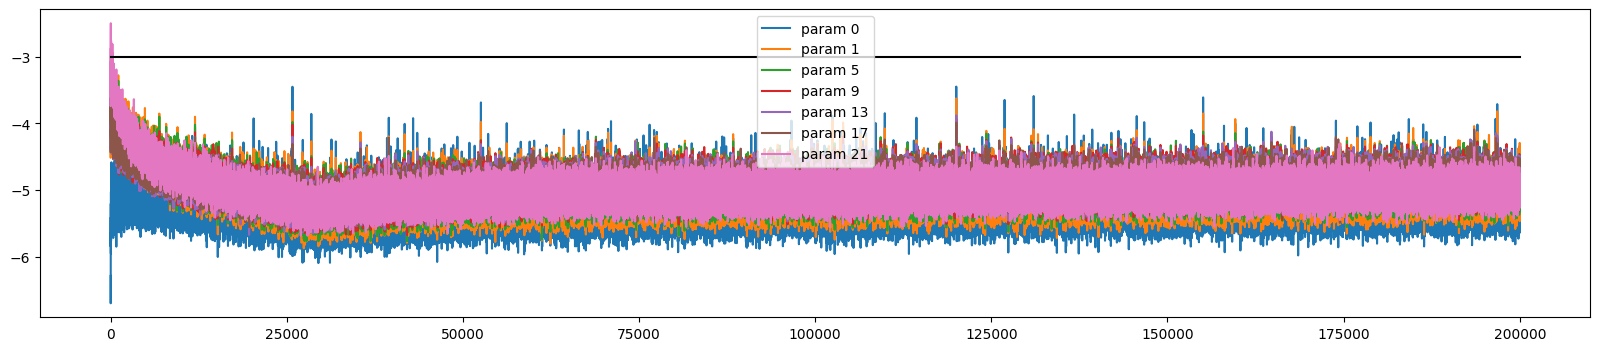

In [81]:
# Visualizing histograms for updates (after multiple steps)
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2: # Only weights, not biases
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

If we play around with the learning rate, the gain and the initialization, the various plots will look pretty resonable! That is, with batch normalization our training is less sensitive to gain and initialization. 

Now we have should have an understanding of batch norm and how to diagnose a neural networks.

In [82]:
# Split loss for pytorch setup
@torch.no_grad()
def split_loss(split: str = 'train', print_loss: bool = False) -> None:
    """
    Description:
        Prints the loss of a chosen split
    Inputs:
        split: train, valid, or test
    """
    x,y = {
        'train': (Xtr, Ytr),
        'valid': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    
    if print_loss:
        print(split, loss.item())
    else :
        return loss.item()

In [83]:
# Evaluating model
for layer in layers:
    layer.training = False
split_loss('train', print_loss=True)
split_loss('valid', print_loss=True)

train 2.058354377746582
valid 2.1129860877990723
